this notebok optimizes xgboost with optuna, using the categorical handling of the method: xgb.XGBClassifier(tree_method="hist", enable_categorical=True). so no onehotencoding is necessary

important steps: 
- label eoncoding of the deck variable 
- log transforming and standardscaling of numerical variables 
- filling nans of Cryosleep to True when all spendings are zero and vice versa 
- filling nans of Cryosleep to False when VIP ==True 


In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt # For plotting chart
import seaborn as sns # For creating data visualization

import os 

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score, KFold 
from sklearn.pipeline import Pipeline 
from sklearn.pipeline import make_pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures,  StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, make_scorer
 
import optuna

import statsmodels.api as sm

import time 

C:\Users\reinh\coding\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('train.csv')

print("interestingly, the age is recorded but not the gender")
df.head(5)

interestingly, the age is recorded but not the gender


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
# Count duplicates and null values 
print(f"Number of duplicates: {df.duplicated().sum()}") 
print(f"Number of null values: {df.isnull().sum()}") 


Number of duplicates: 0
Number of null values: PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


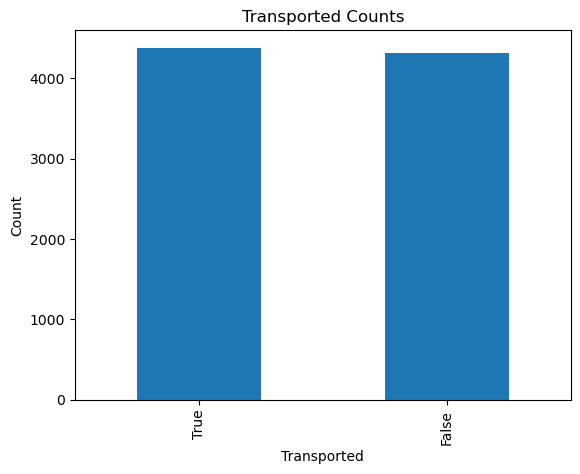

In [6]:
# Count the values of "Transported" column
transported_counts = df['Transported'].value_counts()

# Plotting the bar chart
transported_counts.plot(kind='bar')
plt.title('Transported Counts')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()


In [7]:
print("-> it seems that some cabins have multiple people")  

# persons in cabin 
Cabin_persons = df['Cabin'].value_counts()
df['Cabin_persons'] = df['Cabin'].map(Cabin_persons)
print(df["Cabin_persons"].value_counts())

-> it seems that some cabins have multiple people
Cabin_persons
1.0    5427
2.0    1372
3.0     747
4.0     416
5.0     235
6.0     198
7.0      91
8.0       8
Name: count, dtype: int64


In [8]:
## first it can be a port or starboard cabin -> make a new feature with starboard-cabin
print("\nSides of the cabins: starboard or port")
df["Starboard_Cabin"] = df['Cabin'].str.endswith('S')
df["Starboard_Cabin"] = df["Starboard_Cabin"].astype(object)
print(df["Starboard_Cabin"].value_counts())

## the first letter indicates the deck 
df['Cabin_Deck'] = df['Cabin'].str[0]
print("\nDecks on the ship")
print(f"Number of unique decks:", df["Cabin_Deck"].nunique())
print(df["Cabin_Deck"].value_counts())

#df[df['Cabin'] == 'G/1476/S'][['Cabin', 'Cabin_persons']].head(10)
print(f"Number of null values: {df.isnull().sum()}") 


Sides of the cabins: starboard or port
Starboard_Cabin
True     4288
False    4206
Name: count, dtype: int64

Decks on the ship
Number of unique decks: 8
Cabin_Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64
Number of null values: PassengerId          0
HomePlanet         201
CryoSleep          217
Cabin              199
Destination        182
Age                179
VIP                203
RoomService        181
FoodCourt          183
ShoppingMall       208
Spa                183
VRDeck             188
Name               200
Transported          0
Cabin_persons      199
Starboard_Cabin    199
Cabin_Deck         199
dtype: int64


In [9]:
## family members on board 
pd.set_option('display.max_rows', None)
print(df[['Cabin', 'Name', "Cabin_persons"]].head(20)) 

# the passengerID is need for the submission 

    Cabin                Name  Cabin_persons
0   B/0/P     Maham Ofracculy            1.0
1   F/0/S        Juanna Vines            1.0
2   A/0/S       Altark Susent            2.0
3   A/0/S        Solam Susent            2.0
4   F/1/S   Willy Santantines            1.0
5   F/0/P   Sandie Hinetthews            1.0
6   F/2/S  Billex Jacostaffey            1.0
7   G/0/S  Candra Jacostaffey            1.0
8   F/3/S       Andona Beston            1.0
9   B/1/P      Erraiam Flatic            3.0
10  B/1/P      Altardr Flatic            3.0
11  B/1/P       Wezena Flatic            3.0
12  F/1/P        Berers Barne            1.0
13  G/1/S      Reney Baketton            1.0
14  F/2/P     Elle Bertsontry            1.0
15    NaN       Justie Pooles            NaN
16  F/3/P         Flats Eccle            1.0
17  F/4/P     Carry Hughriend            1.0
18  F/5/P          Alus Upead            1.0
19  G/0/P       Lyde Brighttt            1.0


In [10]:
# destinations 
print(f"\nNumber of unique destinations:", df["Destination"].nunique())
print(df["Destination"].value_counts())
df['Destination'] = df['Destination'].str.replace(' ', '-')


Number of unique destinations: 3
Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64


In [11]:
## Exploratory analysis

relationship between target (transported) and the continous variables


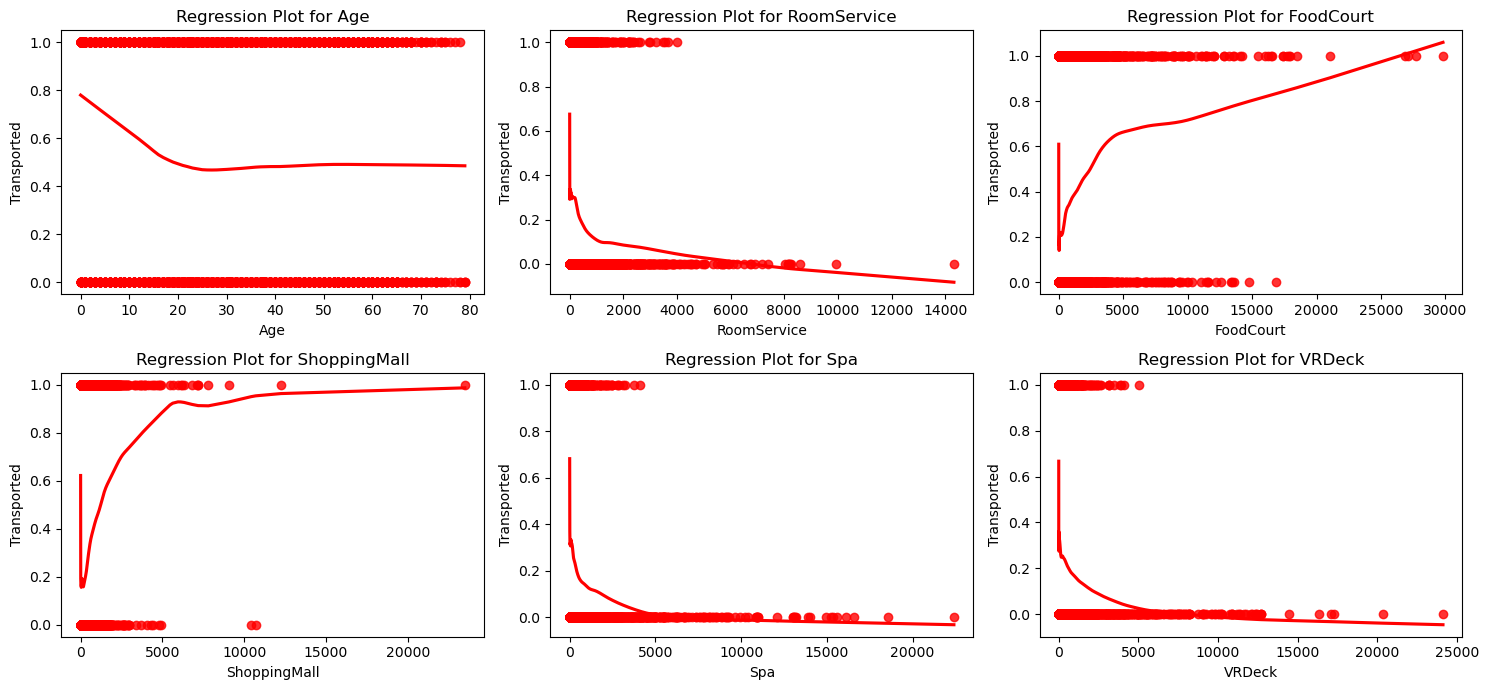

Findings:
->higher spendings for Roomservice and Spa are associated with a lower probability of being transported to another galaxy
-> higher spendings on Foodcourt, Shoppingmall and VRdeck are associated with a higher probability 


In [12]:
print("relationship between target (transported) and the continous variables")

x_variables = ["Age", "RoomService", "FoodCourt", "ShoppingMall" , "Spa", "VRDeck"]

# Calculate the number of rows and columns for subplots
num_cols = 3
num_rows = (len(x_variables) + num_cols - 1) // num_cols  # Ceiling division

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 7))

# Flatten axes if num_rows > 1
axes = axes.flatten() if num_rows > 1 else [axes]

# Iterate over x variables and create regplots
for i, x_var in enumerate(x_variables):
    sns.regplot(x=x_var, y="Transported", data=df, scatter=True, lowess=True, color='r', ax=axes[i])
    axes[i].set_title(f"Regression Plot for {x_var}")
    axes[i].set_xlabel(x_var)
    axes[i].set_ylabel("Transported")

plt.tight_layout()
plt.show()

print("Findings:\n->higher spendings for Roomservice and Spa are associated with a lower probability of being transported to another galaxy\n-> higher spendings on Foodcourt, Shoppingmall and VRdeck are associated with a higher probability ")

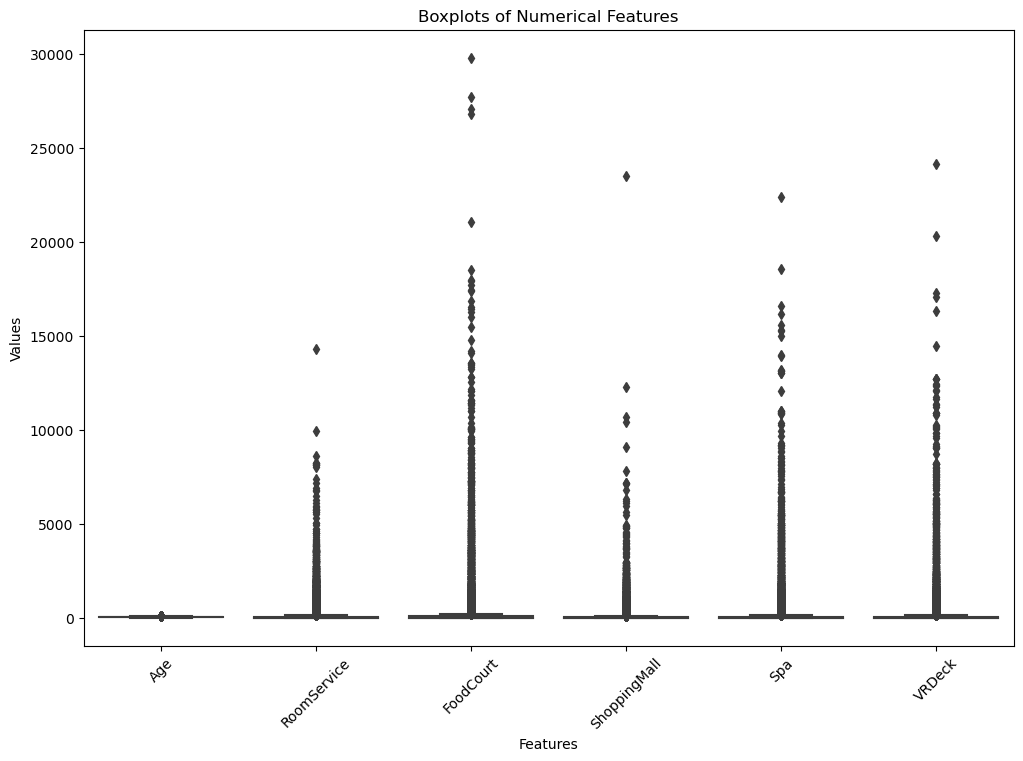

In [13]:
# Create boxplots for each transformed numerical feature
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[x_variables])
plt.title('Boxplots of Numerical Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

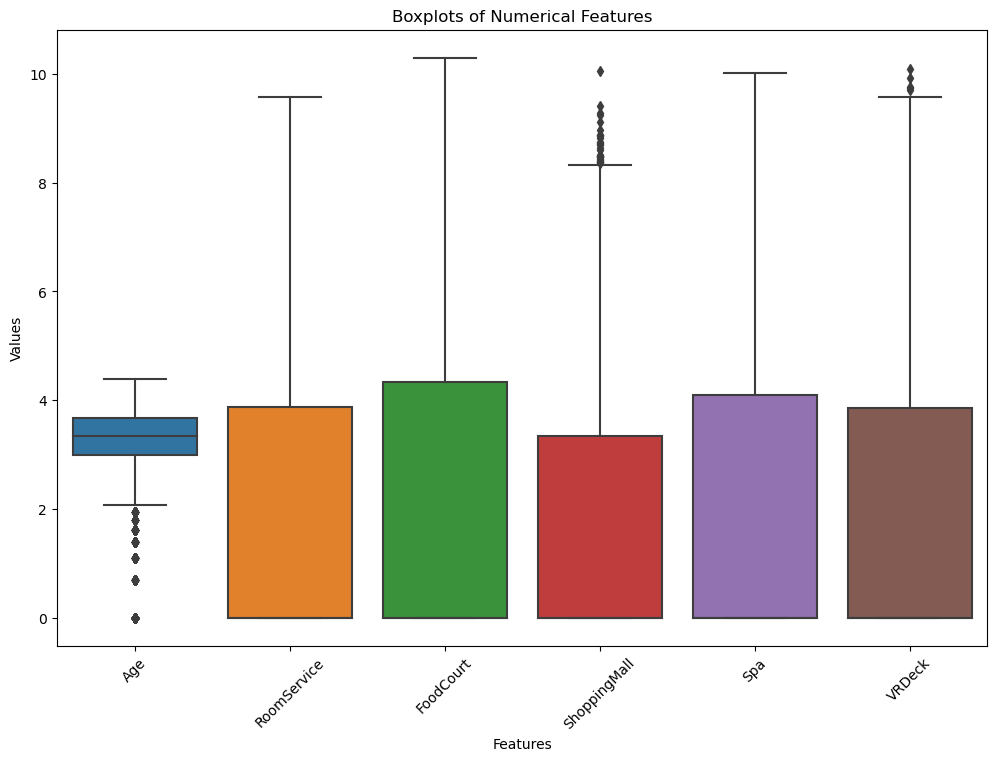

In [14]:
df[x_variables] = np.log1p(df[x_variables])
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[x_variables])
plt.title('Boxplots of Numerical Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()


In [15]:
print(df.columns.values)

['PassengerId' 'HomePlanet' 'CryoSleep' 'Cabin' 'Destination' 'Age' 'VIP'
 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck' 'Name'
 'Transported' 'Cabin_persons' 'Starboard_Cabin' 'Cabin_Deck']


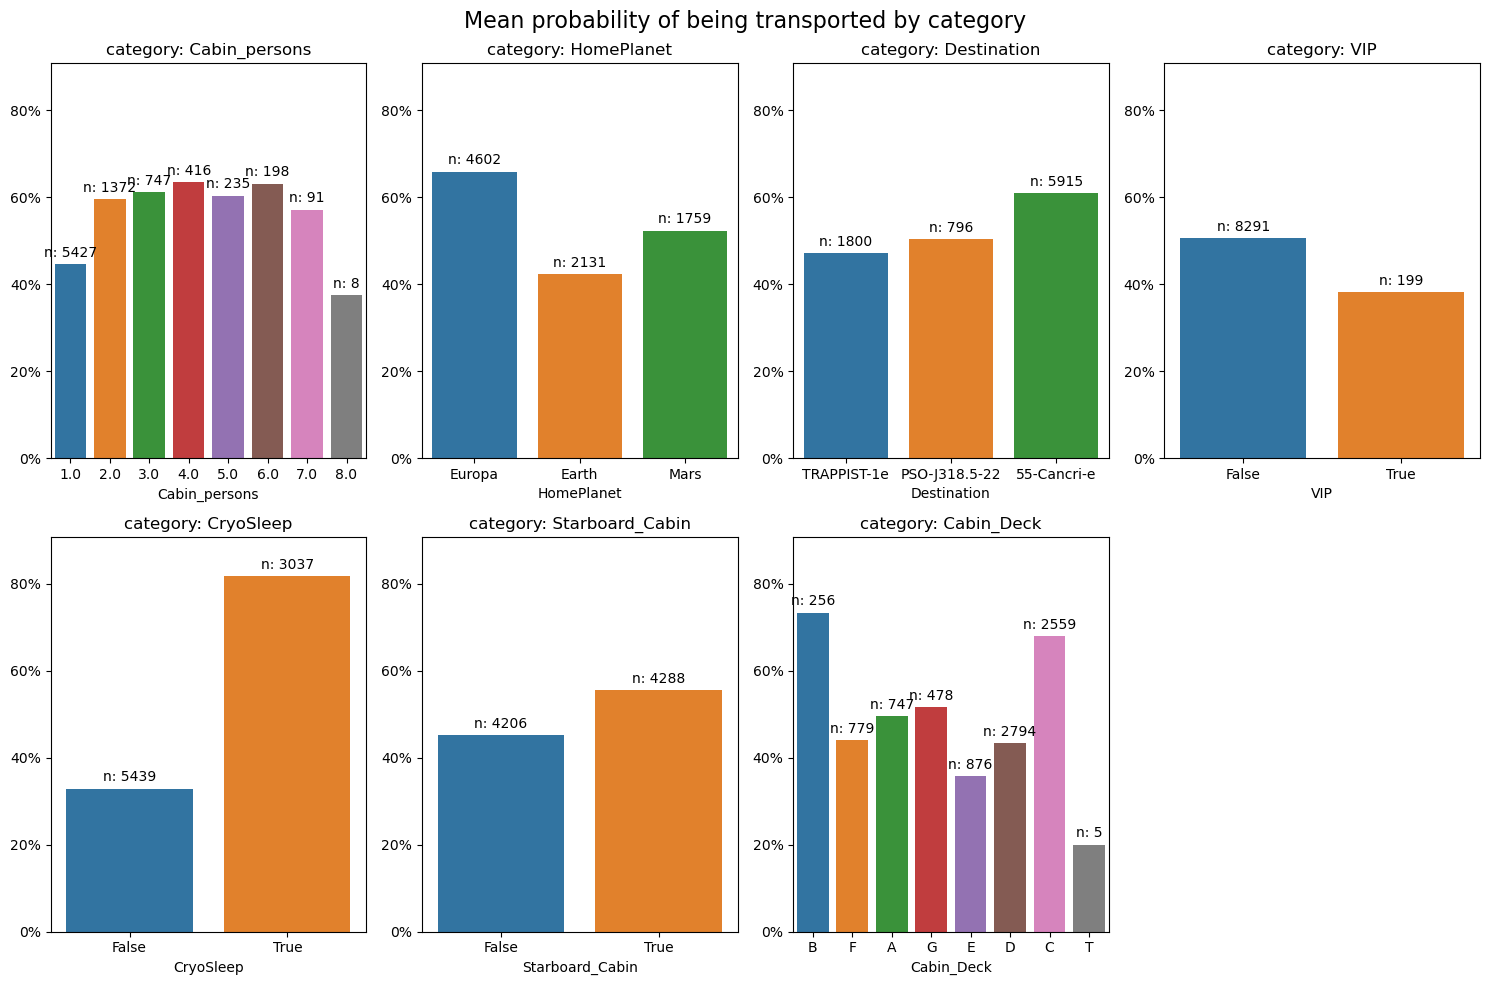

Findings:
->higher spendings for Roomservice and Spa are associated with a lower probability of being transported to another galaxy
-> higher spendings on Foodcourt, Shoppingmall and VRdeck are associated with a higher probability 
-> some decks have higher probability of being transported 
-> people in Cryosleep were being transported more often


In [16]:
from matplotlib.ticker import FuncFormatter

# List of x variables
x_variables = ["Cabin_persons", "HomePlanet", "Destination", "VIP", "CryoSleep", "Starboard_Cabin", "Cabin_Deck"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

# Flatten axes
axes = axes.flatten()

# Initialize variables to store the minimum and maximum y-axis values
min_y = float('inf')
max_y = float('-inf')

# Iterate over x variables and create bar plots
for i, x_var in enumerate(x_variables):
    # Calculate the count of observations for each category
    nobs = df.groupby([x_var])['Transported'].count().values
    # Convert the counts to strings and format them
    nobs = [f'n: {count}' for count in nobs]
    
    # Calculate mean and standard deviation for each category -> needed for the annotation of the number of observations (nobs) 
    means = df.groupby(x_var)['Transported'].mean()
    stds = df.groupby(x_var)['Transported'].std()
    
    # Calculate upper level of confidence intervals
    upper_ci = means + 1.96 * stds / np.sqrt(df.groupby(x_var)['Transported'].count())
    
    # Create the bar plot
    ax = sns.barplot(x=x_var, y='Transported', data=df, ax=axes[i], errorbar=None)
   
    # Add annotations above each bar
    for p,  nobs_value, upper_ci_value in zip(ax.patches, nobs, upper_ci):
        ax.annotate(nobs_value, xy=(p.get_x() + p.get_width() / 2, p.get_height()+0.01),  # adjust the postion for the annotated number of observations 
                    ha='center', va='bottom')

    
    # modify the axis 
    ax.set_title(f"category: {x_var}")
    ax.set_xlabel(x_var)
    ax.set_ylabel("")
    ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    
    # Update the minimum and maximum y-axis values
    min_y = min(min_y, ax.get_ylim()[0])
    max_y = max(max_y, ax.get_ylim()[1])
    
# Set the same y-axis limits for all subplots
for ax in axes:
    ax.set_ylim(min_y, max_y+0.05)

# Hide any empty subplots
for j in range(len(x_variables), len(axes)):
    axes[j].axis('off')
    
# Set overall title
fig.suptitle("Mean probability of being transported by category", fontsize=16)

plt.tight_layout()
plt.show()

print("Findings:\n->higher spendings for Roomservice and Spa are associated with a lower probability of being transported to another galaxy\n-> higher spendings on Foodcourt, Shoppingmall and VRdeck are associated with a higher probability \n-> some decks have higher probability of being transported \n-> people in Cryosleep were being transported more often")

In [17]:
## Feature engineering 

print("-> if someone is in cryoslep he has zero spendings")
print("-> there is (univariately) no difference in the mean target probability for 2 or more persons in the cabin. So I reduce the feature to two categories")
print("-> Deck T has only two entries, small categories can be tricky for forests, so I put decks D and T together -> the ones with the least feature importance")
print("-> log transform numerical variables")

categorical_features = ["CryoSleep", "VIP", "Starboard_Cabin", "Cabin_Deck", "Single_cabin", "Destination", "HomePlanet"]
numerical_features = ["Age", 'RoomService', "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]  

pd.set_option('future.no_silent_downcasting', True) 


# create pipeline for feature engineering to apply to training and test data 
class CustomDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Drop rows with missing values
        X = X.copy()

        # feature engineering 
        spending_categories = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        if X['CryoSleep'].any():  # Check if any value in 'CryoSleep' column is True
             X[spending_categories] = X[spending_categories].fillna(0)   # Fill NaNs in spending categories with zeros 

        # Check if all spending categories are zero
        all_zero_spending = X[spending_categories].eq(0).all(axis=1)
        
        # Set CryoSleep to True where all spending categories are zero
        X.loc[all_zero_spending, 'CryoSleep'] = True
        
        # This code fills NaNs in the 'CryoSleep' column with the value False where the 'VIP' column is True.
        X['CryoSleep'] = X['CryoSleep'].fillna(X['VIP'].eq(True)).infer_objects(copy=False)
    
        # log transform numerical variables 
        X[numerical_features] = np.log1p(X[numerical_features])

        X['Cabin_persons'] = X['Cabin'].map(Cabin_persons)
        X["Starboard_Cabin"] = X['Cabin'].str.endswith('S')
        X['Cabin_Deck'] = X['Cabin'].str[0]
        ## reduce categories 
        X['Cabin_Deck'] = X['Cabin_Deck'].replace({'D': 'DT', 'T': 'DT'})  
        X['Cabin_persons'] = X['Cabin_persons'].replace({3: "3", 4: '>=4', 5: '>=4', 6: ">=4", 7: ">=4", 8: ">=4"})
        X['Single_cabin'] = X['Cabin_persons'].replace({1: True, 2: False, "3": False, ">=4": False})
    
        # drop destinaion as this turned out to be not important feature 
        X['Destination'] = X['Destination'].str.replace(' ', '-')
        #X=X.drop(["Destination"], axis=1)
        #X=X.drop(["HomePlanet"], axis=1)
        X=X.drop(["Cabin_persons"], axis=1)
        return X

# Define your pipeline
pipeline_dataprep = Pipeline(steps=[
    ('custom_transformer', CustomDataTransformer()),
    # Add other preprocessing steps as needed
])

# load the training set and apply the pipeline 
df_train = pd.read_csv('train.csv')
df=pipeline_dataprep.fit_transform(df_train)

-> if someone is in cryoslep he has zero spendings
-> there is (univariately) no difference in the mean target probability for 2 or more persons in the cabin. So I reduce the feature to two categories
-> Deck T has only two entries, small categories can be tricky for forests, so I put decks D and T together -> the ones with the least feature importance
-> log transform numerical variables


In [18]:
## Prepare Data fo ML 

In [19]:
y = df['Transported']
X=df.drop(['Transported', 'PassengerId', 'Name', "Cabin"], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HomePlanet       8492 non-null   object 
 1   CryoSleep        8693 non-null   bool   
 2   Destination      8511 non-null   object 
 3   Age              8514 non-null   float64
 4   VIP              8490 non-null   object 
 5   RoomService      8693 non-null   float64
 6   FoodCourt        8693 non-null   float64
 7   ShoppingMall     8693 non-null   float64
 8   Spa              8693 non-null   float64
 9   VRDeck           8693 non-null   float64
 10  Starboard_Cabin  8494 non-null   object 
 11  Cabin_Deck       8494 non-null   object 
 12  Single_cabin     8494 non-null   object 
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB


In [20]:
print(f"Number of null values:\n{df.isnull().sum()}") 

Number of null values:
PassengerId          0
HomePlanet         201
CryoSleep            0
Cabin              199
Destination        182
Age                179
VIP                203
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Name               200
Transported          0
Starboard_Cabin    199
Cabin_Deck         199
Single_cabin       199
dtype: int64


In [21]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Starboard_Cabin,Cabin_Deck,Single_cabin
0,0001_01,Europa,True,B/0/P,TRAPPIST-1e,3.688879,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,False,B,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,3.218876,False,4.700480,2.302585,3.258097,6.309918,3.806662,Juanna Vines,True,True,F,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,4.077537,True,3.784190,8.182280,0.000000,8.812248,3.912023,Altark Susent,False,True,A,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,3.526361,False,0.000000,7.157735,5.918894,8.110728,5.267858,Solam Susent,False,True,A,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,2.833213,False,5.717028,4.262680,5.023881,6.338594,1.098612,Willy Santantines,True,True,F,True


## Begin ML 


In [22]:
# prepare for ML 

# use the training set to train and validate the model 
y = df['Transported']
X=df.drop(['Transported', 'PassengerId', 'Name', "Cabin"], axis=1)

# Define feature names
categorical_features = ["CryoSleep", "VIP", "Starboard_Cabin", "Cabin_Deck", "Single_cabin", "Destination", "HomePlanet"]
numerical_features = ["Age", 'RoomService', "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]  

# make categorical variables for use in xgboost 
X[categorical_features].astype("category")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=9874654)

# Define transformers
categorical_transformer = Pipeline(steps=[
        ('impute_mode', SimpleImputer(strategy='most_frequent'))
        #('onehot', OneHotEncoder(handle_unknown='ignore'))       # drop="first" if use non-regularized  
        ])   

numerical_transformer = Pipeline(steps=[('KNN_imputer', KNNImputer(n_neighbors=5)), ('scaler', StandardScaler())])

label_transformer = Pipeline(steps=[('label_encoder', LabelEncoder())]) 
                             

# Define preprocessor 
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features), 
        ('num', numerical_transformer, numerical_features)
    ]
)

## check if it worked: 

# Fit and transform the data using the preprocessor
X_transformed = preprocessor.fit_transform(X_train)

# Get the feature names after one-hot encoding
feature_names_categorical = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names_numerical = numerical_features
feature_names = list(feature_names_categorical) + feature_names_numerical

# Concatenate the transformed numerical features and one-hot encoded categorical features
transformed_data = pd.DataFrame(
    data=X_transformed,
    columns=feature_names # concatenate feature names
)

# Display the transformed data as a DataFrame
transformed_data.isnull().sum()

CryoSleep          0
VIP                0
Starboard_Cabin    0
Cabin_Deck         0
Single_cabin       0
Destination        0
HomePlanet         0
Age                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
dtype: int64

In [23]:
print(X_train.dtypes)

HomePlanet          object
CryoSleep             bool
Destination         object
Age                float64
VIP                 object
RoomService        float64
FoodCourt          float64
ShoppingMall       float64
Spa                float64
VRDeck             float64
Starboard_Cabin     object
Cabin_Deck          object
Single_cabin        object
dtype: object


In [24]:
transformed_data.head()

,CryoSleep,VIP,Starboard_Cabin,Cabin_Deck,Single_cabin,Destination,HomePlanet,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,False,False,False,C,False,55-Cancri-e,Europa,0.16896,-0.633403,2.351875,2.022816,1.135754,1.918481
1,True,False,False,A,False,TRAPPIST-1e,Europa,0.463836,-0.633403,-0.651063,-0.617485,-0.665958,-0.643284
2,False,False,False,DT,True,TRAPPIST-1e,Earth,0.501063,1.590066,1.791314,-0.617485,0.307796,0.847909
3,False,False,True,G,True,TRAPPIST-1e,Earth,0.766243,-0.377845,-0.651063,1.482929,0.081762,1.734114
4,True,False,False,F,False,TRAPPIST-1e,Mars,-0.950714,-0.633403,-0.651063,-0.617485,-0.665958,-0.643284


In [25]:
for column in categorical_features:
    unique_values = transformed_data[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'CryoSleep': [False True]
Unique values in column 'VIP': [False True]
Unique values in column 'Starboard_Cabin': [False True]
Unique values in column 'Cabin_Deck': ['C' 'A' 'DT' 'G' 'F' 'B' 'E']
Unique values in column 'Single_cabin': [False True]
Unique values in column 'Destination': ['55-Cancri-e' 'TRAPPIST-1e' 'PSO-J318.5-22']
Unique values in column 'HomePlanet': ['Europa' 'Earth' 'Mars']


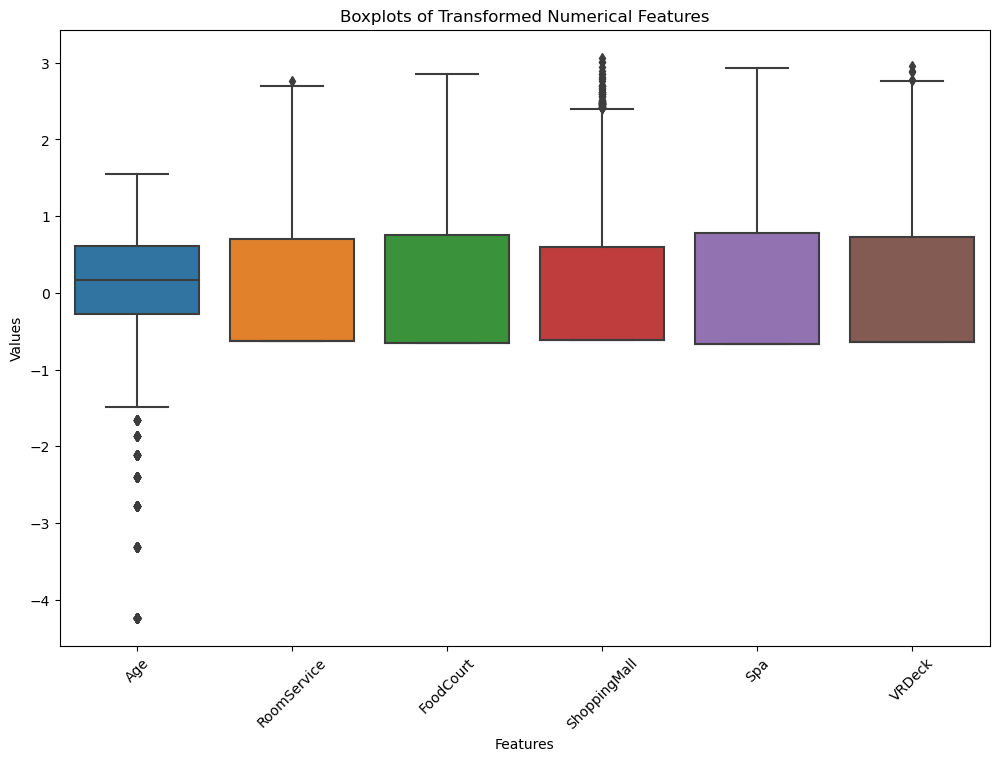

In [26]:
# Define numerical features after transformation
transformed_numerical_features = ["Age", 'RoomService', "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# Create boxplots for each transformed numerical feature
plt.figure(figsize=(12, 8))
sns.boxplot(data=transformed_data[transformed_numerical_features])
plt.title('Boxplots of Transformed Numerical Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

In [27]:
import joblib

# encoode categorical features to be used in xgboost -> i could not get this to work in the pipeline  
label_encoder = LabelEncoder()
X_train['Cabin_Deck'] = label_encoder.fit_transform(X_train['Cabin_Deck'])
X_train['Destination'] = label_encoder.fit_transform(X_train['Destination'])
X_train['HomePlanet'] = label_encoder.fit_transform(X_train['HomePlanet'])

X_test['Cabin_Deck'] = label_encoder.fit_transform(X_test['Cabin_Deck'])
X_test['Destination'] = label_encoder.fit_transform(X_test['Destination'])
X_test['HomePlanet'] = label_encoder.fit_transform(X_test['HomePlanet'])

# Define models
models = [
    ('xgboost(default)', xgb.XGBClassifier(tree_method="hist", enable_categorical=True, random_state=897465162))
    ]

trained_models = {}

# Fit and evaluate each model
for name, model in models:
    # Record start time
    start_time = time.time()
    
    # Pipeline for imputation of categorical and numerical values and scaling numerical values 
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit pipeline to training data
    pipeline.fit(X_train, y_train)
    
    # save the classifiers 
    joblib.dump(pipeline, f"{name}_trained.joblib")
    
    # Make predictions on training data
    y_train_pred = pipeline.predict(X_train)
    
    # Calculate training accuracy
    accuracy_train = accuracy_score(y_train, y_train_pred)
    
    # Make predictions on test data
    y_test_pred = pipeline.predict(X_test)
    # Calculate test accuracy
    accuracy_test = accuracy_score(y_test, y_test_pred)
    
    # Record end time and calculate elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time  
    
    # save the classification report 
    report_str = classification_report(y_test, y_test_pred)
    file_name = f"CR_{name}.txt"
    file_path = "classification_report.txt"
    file_path = os.path.join("reports", file_name)  # Assumes a directory named 'classification_reports' exists
    with open(file_path, "w") as file:
        file.write(report_str)
    
    # display metrics 
    print(f"\n#### Model: {name}")
    print("Overfitting?")
    print(f"- training Accuracy: {round(accuracy_train, 4)} , test Accuracy: {round(accuracy_test, 4)}")
    
    print(f"\nClassification report for model: {name} (elapsed time: {elapsed_time:.5f} seconds):")
    
    # Open and print the file in read mode
    with open(file_path, "r") as file:
        report_contents = file.read()
    print(report_contents)
    print(f"Classification report saved to {file_path}")
    
    # Create DataFrame for confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm, index=["Actual Class 0", "Actual Class 1"], columns=["Predicted Class 0", "Predicted Class 1"])
    print("\nConfusion Matrix:")
    print(cm_df)
    
    #save CM 
    cm_file_path = f"reports\CM_{name}.csv"
    cm_df.to_csv(cm_file_path, index=True)
    
    print(f"\nConfusion matrix saved to {cm_file_path}")
    
    # Store the trained model in the dictionary
    trained_models[name] = pipeline


#### Model: xgboost(default)
Overfitting?
- training Accuracy: 0.909 , test Accuracy: 0.7999

Classification report for model: xgboost(default) (elapsed time: 0.22209 seconds):
              precision    recall  f1-score   support

       False       0.79      0.80      0.79      1388
        True       0.81      0.80      0.80      1481

    accuracy                           0.80      2869
   macro avg       0.80      0.80      0.80      2869
weighted avg       0.80      0.80      0.80      2869

Classification report saved to reports\CR_xgboost(default).txt

Confusion Matrix:
                Predicted Class 0  Predicted Class 1
Actual Class 0               1112                276
Actual Class 1                298               1183

Confusion matrix saved to reports\CM_xgboost(default).csv


In [28]:
gbt_model = trained_models['xgboost(default)']

# Get feature importances
feature_importances = gbt_model.named_steps['model'].feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(importance_df)

            Feature  Importance
0         CryoSleep    0.855230
6        HomePlanet    0.036070
3        Cabin_Deck    0.016499
9         FoodCourt    0.013780
12           VRDeck    0.012440
11              Spa    0.012033
10     ShoppingMall    0.010919
2   Starboard_Cabin    0.009302
8       RoomService    0.008742
5       Destination    0.007327
1               VIP    0.006758
7               Age    0.005995
4      Single_cabin    0.004906


#### not so good accuracy yet, try improving hyperparameters using Optuna

#### for Xgboost 

In [29]:
def objective(trial):
    # Define hyperparameters to be optimized
    params_xgboost= {
        'tree_method': 'hist',
        'enable_categorical': 'True',
        'objective': 'binary:logistic',   # Use 'binary:logistic' for binary classification
        'eval_metric': 'error',           # Use 'error' for binary classification error rate
        'n_estimators': trial.suggest_int('n_estimators', 300, 10000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 15),                # decrease to reduce overfitting 
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.05),  # decrease to reduce overfitting  
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),   # decrease to reduce overfitting  
        'reg_alpha': trial.suggest_float('reg_alpha', 0.2, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.2, 10.0),
        'random_state': 897465162
    } 
        
    model = xgb.XGBClassifier(**params_xgboost)
    
    # Create pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    X['Cabin_Deck'] = label_encoder.fit_transform(X['Cabin_Deck'])
    X['Destination'] = label_encoder.fit_transform(X['Destination'])
    X['HomePlanet'] = label_encoder.fit_transform(X['HomePlanet'])
    
    # Evaluate model using cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=584646231)
    roc_auc_scorer = make_scorer(roc_auc_score, response_method="predict_proba") 
    scores = cross_val_score(pipeline, X, y, scoring=roc_auc_scorer, cv=kf, n_jobs=-1)   # use the whole training set for hyperparameter tuning  # one can switch to the other score 
    return scores.mean()
    # return np.min([np.mean(scores), np.median([scores])])   # alternative to avoid picking extreme trials , my reduce overfitting 

# Create study object and optimize hyperparameters
start_time = time.time()

best_xgboost = optuna.create_study(study_name='xgboost_opt', direction='maximize')
best_xgboost.optimize(objective, n_trials=100)

# Get the best hyperparameters for random forest 
best_params_xgboost = best_xgboost.best_params
end_time = time.time()
elapsed_time = (end_time - start_time)/60

print(f"elapsed time: {elapsed_time:.2f} minutes:")
print("Best hyperparameters found:", best_params_xgboost)

[I 2024-04-28 13:44:35,639] A new study created in memory with name: xgboost_opt
[I 2024-04-28 13:45:02,883] Trial 0 finished with value: 0.887925231076079 and parameters: {'n_estimators': 9611, 'learning_rate': 0.0011979497496715412, 'max_depth': 12, 'subsample': 0.9, 'colsample_bytree': 0.6419622676327029, 'reg_alpha': 9.727719316279352, 'reg_lambda': 6.127250267500811}. Best is trial 0 with value: 0.887925231076079.
[I 2024-04-28 13:45:06,923] Trial 1 finished with value: 0.8870260123646976 and parameters: {'n_estimators': 875, 'learning_rate': 0.00728119564622173, 'max_depth': 9, 'subsample': 0.6, 'colsample_bytree': 0.9129213475281448, 'reg_alpha': 5.693809706344382, 'reg_lambda': 5.237383836877635}. Best is trial 0 with value: 0.887925231076079.
[I 2024-04-28 13:45:11,709] Trial 2 finished with value: 0.884609003815109 and parameters: {'n_estimators': 2403, 'learning_rate': 0.0017646953229197215, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8689006905737469, 'reg_alpha

elapsed time: 29.72 minutes:
Best hyperparameters found: {'n_estimators': 7877, 'learning_rate': 0.001072757874529383, 'max_depth': 7, 'subsample': 0.7, 'colsample_bytree': 0.9300547962408714, 'reg_alpha': 0.27203395788698015, 'reg_lambda': 9.218635738580666}


In [30]:
# compare all the forests 
## copy the pipeline from above with using the best params 
#best_params_rf= {'n_estimators': 577, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 0.3}
# best_params_boosted_rf={'n_estimators': 842, 'learning_rate': 0.01, 'max_depth': 6, 'subsample': 0.7739727178127068, 'min_samples_split': 72, 'min_samples_leaf': 85, 'max_features': None}

# best_params_xgboost= {'n_estimators': 7877, 'learning_rate': 0.001072757874529383, 'max_depth': 7, 'subsample': 0.7, 'colsample_bytree': 0.9300547962408714, 'reg_alpha': 0.27203395788698015, 'reg_lambda': 9.218635738580666} 

# Define models
models = [ 
    #('Random Forest classifier (optimized)', RandomForestClassifier(**best_params_rf, random_state=584646231)), 
    #('Gradient boosted classifier (optimized)', GradientBoostingClassifier(**best_params_boosted_rf, random_state=584646231))
    ("xgboost (optimized)",xgb.XGBClassifier(tree_method="hist", enable_categorical=True ,**best_params_xgboost, random_state=897465162))
    ]

trained_models_opt = {}

# Fit and evaluate each model
for name, model in models:
    # Record start time
    start_time = time.time()
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit pipeline to training data
    pipeline.fit(X_train, y_train)

    # Make predictions on training data
    y_train_pred = pipeline.predict(X_train)
    # Calculate training accuracy
    accuracy_train = accuracy_score(y_train, y_train_pred)
    
    # Make predictions on test data
    y_test_pred = pipeline.predict(X_test)
    # Calculate test accuracy
    accuracy_test = accuracy_score(y_test, y_test_pred)
         
    # Record end time and calculate elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time  
    
    # save the classification report 
    report_str = classification_report(y_test, y_test_pred)
    file_name = f"CR_{name}.txt"
    file_path = "classification_report.txt"
    file_path = os.path.join("reports", file_name)  # Assumes a directory named 'classification_reports' exists
    with open(file_path, "w") as file:
        file.write(report_str)
    
    # display metrics 
    print(f"\n#### Model: {name}")
    print("Overfitting?")
    print(f"- training Accuracy: {round(accuracy_train, 4)} , test Accuracy: {round(accuracy_test,4)}")
    
    print(f"\nClassification report for model: {name} (elapsed time: {elapsed_time:.5f} seconds):")

    # Open and print the file in read mode
    with open(file_path, "r") as file:
        report_contents = file.read()
    print(report_contents)
    print(f"Classification report saved to {file_path}")
    
    # Create DataFrame for confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm, index=["Actual Class 0", "Actual Class 1"], columns=["Predicted Class 0", "Predicted Class 1"])
    print("\nConfusion Matrix:")
    print(cm_df)
    
    #save CM 
    cm_file_path = f"reports\CM_{name}.csv"
    cm_df.to_csv(cm_file_path, index=True)
    
    print(f"\nConfusion matrix saved to {cm_file_path}")
    
    # Store the trained model in the dictionary
    trained_models_opt[name] = pipeline



#### Model: xgboost (optimized)
Overfitting?
- training Accuracy: 0.8462 , test Accuracy: 0.8062

Classification report for model: xgboost (optimized) (elapsed time: 9.08613 seconds):
              precision    recall  f1-score   support

       False       0.79      0.81      0.80      1388
        True       0.82      0.80      0.81      1481

    accuracy                           0.81      2869
   macro avg       0.81      0.81      0.81      2869
weighted avg       0.81      0.81      0.81      2869

Classification report saved to reports\CR_xgboost (optimized).txt

Confusion Matrix:
                Predicted Class 0  Predicted Class 1
Actual Class 0               1123                265
Actual Class 1                291               1190

Confusion matrix saved to reports\CM_xgboost (optimized).csv


In [31]:
## display metrics for Gradient boosted Random forest (sklearn default) with default settings  for comparison 

print(f"\n#### Gradient boosted Random forest (sklearn default): \nclassification report")
file_path = "classification_reports/CR_Gradient boosted classifier (sklearn default).txt"
with open(file_path, "r") as file:
    report_contents = file.read()
print(report_contents)

# Read the confusion matrix DataFrame from the CSV file
cm_df_saved = pd.read_csv("reports/CM_Gradient boosted classifier (sklearn default).csv", index_col=0)
# Display the confusion matrix DataFrame
print("Confusion Matrix:")
print(cm_df_saved)


#### Gradient boosted Random forest (sklearn default): 
classification report
              precision    recall  f1-score   support

       False       0.82      0.77      0.79      1062
        True       0.79      0.84      0.81      1118

    accuracy                           0.80      2180
   macro avg       0.81      0.80      0.80      2180
weighted avg       0.80      0.80      0.80      2180

Confusion Matrix:
                Predicted Class 0  Predicted Class 1
Actual Class 0               1062                326
Actual Class 1                248               1233


In [32]:
gbt_model = trained_models_opt['xgboost (optimized)']

# Get feature importances
feature_importances = gbt_model.named_steps['model'].feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(f"Feature importance for xgboost:\n {importance_df}")

Feature importance for xgboost:
             Feature  Importance
0         CryoSleep    0.820383
6        HomePlanet    0.036882
3        Cabin_Deck    0.021540
11              Spa    0.019031
9         FoodCourt    0.018502
12           VRDeck    0.018331
10     ShoppingMall    0.015092
8       RoomService    0.014850
2   Starboard_Cabin    0.011095
5       Destination    0.008345
7               Age    0.006314
1               VIP    0.004903
4      Single_cabin    0.004733


## Submission 

In [33]:
# load the training set, preprocess it, then train and validate the model 
train_df=pd.read_csv('train.csv')

train_df=pipeline_dataprep.fit_transform(train_df)
y_train = train_df['Transported']
X_train=train_df.drop(['Transported', 'PassengerId', 'Name', "Cabin"], axis=1)

X_train['Cabin_Deck'] = label_encoder.fit_transform(X_train['Cabin_Deck'])
X_train['Destination'] = label_encoder.fit_transform(X_train['Destination'])
X_train['HomePlanet'] = label_encoder.fit_transform(X_train['HomePlanet'])
    

# load the test set and apply the preprocessing-pipeline 
test_df= pd.read_csv('test.csv')
test_df=pipeline_dataprep.fit_transform(test_df)

submission_id = test_df.PassengerId
X_test=test_df.drop(['PassengerId', 'Name', "Cabin"], axis=1)

X_test['Cabin_Deck'] = label_encoder.fit_transform(X_test['Cabin_Deck'])
X_test['Destination'] = label_encoder.fit_transform(X_test['Destination'])
X_test['HomePlanet'] = label_encoder.fit_transform(X_test['HomePlanet'])
    

## check
print(y_train.shape, X_train.shape, X_test.shape)


(8693,) (8693, 13) (4277, 13)


In [34]:
# get predictions for test data 
models = [ 
    #('Gradient boosted classifier (optimized)', GradientBoostingClassifier(**best_params_boosted_rf, random_state=584646231)), 
    ("xgboost (optimized)",xgb.XGBClassifier(**best_params_xgboost))
    ]

# Fit and evaluate each model
for name, model in models:
    # Record start time
    start_time = time.time()
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit pipeline to training data
    pipeline.fit(X_train, y_train)

    # Make predictions on test data
    predictions = pipeline.predict(X_test)
    n_predictions = (predictions > 0.5).astype(bool)
    output = pd.DataFrame({'PassengerId': submission_id,
                               'Transported': n_predictions.squeeze()})

    output.head()
    output.to_csv(f'submissions/submission{name}.csv', index=False)
